## Dynamic Transmission Risk ##

### Structure ###

In [SIR: Factors Influencing Spread](sir.ipynb), we assumed a constant daily rate of transmission risk during the infectious period. This is in keeping with the SIR model, however, in reality we know that transmission risk is influenced by an infected person's viral load, which is a dynamic property.

Here we will demonstrate how to incorporate dynamic transmission risk and compare its impact to the outcomes of the SIR simulations. 

The model and parameters used in this scenario are derived from a paper from the [Fred Hutchinson Cancer Research Center](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf), henceforth known as the Hutch model.

In particular, the Hutch model requires the following parameters in a Gamma-distributed contact regime:

* average of 4 contacts per day per subject, $\overline{k}$
* dispersion of 40, $\theta$
* These parameters should result in $R_0$ 1.8.

This is achieved using [Events](concepts.ipynb#Events). See [Sizing](sizing.ipynb#Complex-Environments) for a detailed demonstration.

The group structure continues to be informed by [CDC Best Planning Scenario](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html) guidelines for IFR.

Other assumptions:

* Population of 10,000
    * proportionately split among the 4 age groups to match [US Census data](https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf).
* Initial Infected of 2
* Duration of Immunity 365 days
* Density of 1 dot / location (excluding the vbox)
* a collection of 9,142 separate events, each recurring every 30 days.

The transmission risk curve used in these simulations is visualized below. See [Hutch Model](theory.ipynb#Dynamic-Transmission-Risk) for the derivation.

<img 
    src='https://storage.googleapis.com/rknotvids/imgs/tmr_curve.png'
    alt='Drawing' style='display: block; margin: 0 auto;'
/>

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime as dt
import numpy as np

from IPython.core.display import HTML, display

from rknot.notebook import md, modulereload, curve_table, animHTML
from rknot.helpers import get_results, find_means, find_means_seconly, find_seconly
import rknot.styles as styles

In [2]:
### HIDDEN ###
RUN = False
SAVE = False
SAVE_CHARTS = False
PATH = 'vids/us_w_load/tests/'

fps = 10
chart_params = dict(use_init_func=False, show_intro=False, dotsize=0.1, h_base=10, interval=1000/fps)
writer_params = dict(fps=fps, bitrate=11000)
save_params = dict(dpi=1000)

### 1. Events ###

Here we show the basic outcome of dynamic viral load in a gamma-distributed contacts environment.

The transmission curve has bee calculated separately and is available as `tmr` from the `rknot.dots.fhutch` module.

All of the 9,000+ events occur in the "Events" vbox. All events have capacities of 3 subjects or more.

Again, details on the event structure are found [here](sizing.ipynb#Complex-Environments).

```python
from rknot import Sim, Chart

from rknot.dots.fhutch import tmr
from rknot.sims.us_w_load_18 import events

group1 = dict(name='0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group2 = dict(name='20-49', n=4100, n_inf=1, ifr=0.0002, mover=.98)
group3 = dict(name='50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group4 = dict(name='70+', n=900, n_inf=0, ifr=0.054, mover=.98)

vbox = {'label': 344, 'box': 344}
params = {'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 'vboxes': vbox, 'events': events}

sim = Sim(groups=groups, events=events, **params)
sim.run()

chart = Chart(sim).to_html5_video()
```

In [3]:
if RUN:
    from rknot import Sim, Chart
    from rknot.sims import us_w_load_18
    from rknot.sim import recycler
    
    modulereload(us_w_load_18)
    
    assert 'susf' not in us_w_load_18.groups[1]   
    assert all(g['mover'] == .98 for g in us_w_load_18.groups)
    
    
    sim_cycler = recycler(100)
    while True:
        for event in us_w_load_18.params['events']:
            event.recurring = 30
    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        print (res[1], .38 < res[1] < .43)
        if .38 < res[1] < .43:
            sim.shutdown()
            break

In [4]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/events'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

In [5]:
if SAVE_CHARTS:
    from rknot import Chart
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'events.mp4')

In [6]:
from rknot.notebook import animHTML
display(HTML(animHTML('us_w_load/events')))

The results are:

In [7]:
import shelve
sirfile = 'vids/baseus/tables'

with shelve.open(sirfile, writeback=True) as db:
    sir_res = db['5']

sir_res = np.char.strip(sir_res, '%').astype(np.float)
sir_res[:6] /= 100

headers = ['Hutch', 'SIR']
results = [res, sir_res]
display(HTML(curve_table(headers, results, style='results')))

,Hutch,SIR
Peak,35.6%,29.0%
HIT,42.4%,56.0%
Total,50.2%,82.0%
Fatalities,0.30%,0.50%
%>70,80.0%,39.0%
IFR,0.60%,0.61%
Days to Peak,63,77


The results relative to the [SIR Events](sir.ipynb#5.-Events) simulation are lower across the board, which is mainly attributable to the lower $R_0$ utilized. With $R_0$ of 1.8, we would expect HIT of ~44%, which is close to the result here. 

There are two other important differences:

+ the peak occurs earlier 
+ there is a narrower range between peak/hit/total infections

These differences result for a couple reasons:

1. in the Hutch model used here, the infection duration is 30 days, double that used in SIR. Thus, as new infections occur, there are fewer recoveries.
2. while the infection duration is longer, the likelihood of infection is highly concentrated in the 3 to 5 day period of peak viral load. Thus, to achieve the same $R_0$, there must be more infections sooner. By the same token, as herd immunity is reached and more infections reach later life cycle, there are fewer infections to extend the tail.

Fatality measures are inline with expectations from SIR model.

Using the `looper` function demonstrated in [Sizing](sizing.ipynb), we can quickly generate a sample of simulations to determine patterns.

The table below shows the results of 250 iterations of this scenario:

In [8]:
import numpy as np
from rknot.notebook import curve_table

from rknot.helpers import ShelfHelp

file = 'tests/data/sizing_complex'
key = 'complex_1.8_iters_RESULTS_n_inf_2'

args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c1, nsecs1, res1 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



In [9]:
headers = ['Events', r'Events <br> $R_0$ > 0']

means1 = find_means(res1)
means1_gt0 = find_means_seconly(res1, means1)
sizes = [res1.shape[0], find_seconly(res1).shape[0]]
args = [means1, means1_gt0]
    
display(HTML(curve_table(headers, args, sizes)))

,Events,Events $R_0$ > 0
n,250,68
Peak,8.9%,32.7%
HIT,11.1%,40.6%
Total,14.0%,51.5%
Fatalities,0.08%,0.30%
%>70,6.5%,6.5%
IFR,0.55%,0.60%
Days to Peak,24,74
$R_0$ = 0,51.6%,0.0%


The chart below shows the distribution of HIT for each of the 250 simulations. The vast majority of simulations resulted in no secondary infections (i.e. an outbreak never occured). Where an outbreak did take hold, outcomes centered around ~40% HIT.

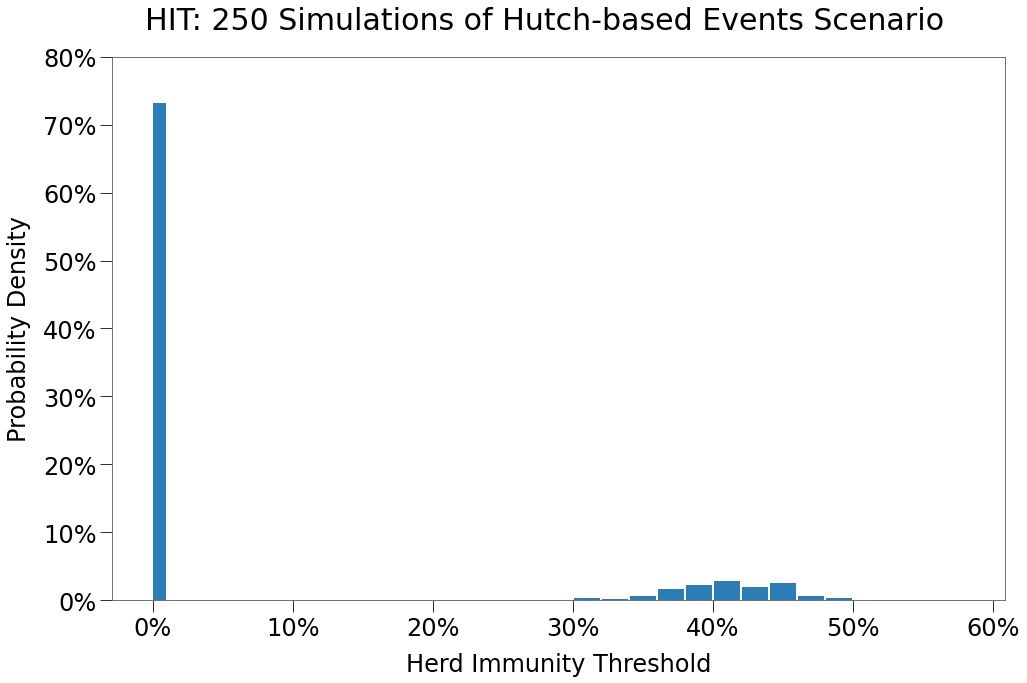

In [10]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/events_hist'

title = r'HIT: 250 Simulations of Hutch-based Events Scenario'
curvehist([res1[:,1]], title=title, which='hit', savepath=savepath)

### 2. Gates ###

We replicate the [SIR Gates scenario](sir.ipynb#6.-Gates) by creating a separate group of  elderly isolated within a gate, intended to simulate care homes or assisted living centers.

One augmentation is made: a small group of care home workers are added that will reqularly enter the gate to service residents. The care home workers will be drawn from the `20-49` age group.

The new groups are:

* `group2b`
    * population of 66
    * Assuming [2.2MM care home workers in the United States](http://phinational.org/wp-content/uploads/legacy/phi-home-care-workers-key-facts.pdf) out of a population of 330MM.
    * remaining attributes similar to `20-49`
    * events individual travel events for half the group, recurring every day
* `group4a`
    * population of 600 (2/3s of `group4`) 
    * IFR of 4.2%
    * remaining attributes mathcing prior `70+` group
* `group4b`
    * population of 300 (1/3rd of `group4`)
    * 25 locations
    * IFR of 7.8%
    * 'local' mover function
    * not eligible for any events

`group4b` used the `local` mover and its gated area has increased density. This is perhaps counter-intuitive. Care home residents are likely more well-mixed than the broader population and more closely follow normally-distributed contacts. So we approximate increased mixing with a higher `p-value`. Ideally, contact distribution in such environments would be researched for guidance.

The event vbox has been adjusted to include the 5 groups that are not gated.

```python
from rknot import Sim, Chart
from rknot.events import Travel
from rknot.dots.fhutch import tmr

from rknot.sims import us_w_load_18

group1 = dict(name='0-19', n=2700, n_inf=0, ifr=0.00003, mover=.98)
group2a = dict(name='20-49', n=4034, n_inf=1, ifr=0.0002, mover=.98)
group2b = dict(name='HCW', n=66, n_inf=0, ifr=0.0002, mover=.98)
group3 = dict(name='50-69', n=2300, n_inf=1, ifr=0.005, mover=.98)
group4a = dict(name='70+', n=600, n_inf=0, ifr=0.042, mover=.98)
group4b = dict(name='70+G', n=300, n_inf=0, ifr=0.0683, mover='local', box=[1,5,1,5], box_is_gated=True)

groups = [group1, group2a, group2b, group3, group4a, group4b]

for e in us_w_load_18.events:
    e.groups = [0,1,2,3,4]

visit = Travel(name='visit', xy=[1,1], start_tick=3, groups=[1,3,4], capacity=1, duration=1, recurring=1)

works = []
for i in range(group2b['n'] // 2):
    loc  = np.random.randint(1, 11, size=(2,)) 
    work = Travel(name=f'hcw-work-{i}', xy=loc, start_tick=1, groups=[2], capacity=1, duration=1, recurring=1)
    works.append(work)

for e in events_gated:
    e.groups = [0,1,2,3,4]
events_gated = events_gated + [visit] + works

vbox = {'label': 'Events', 'box': 344}
params = {'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 'vboxes': vbox, 'events': us_w_load_18.events}

sim = Sim(**params)
sim.run(dotlog=True)

chart = Chart(sim).to_html5_video()
```

In [11]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

modulereload(us_w_load_18)

assert 'susf' not in us_w_load_18.groups[1]

In [12]:
file = 'tests/data/load_gates'
key = 'load_gates_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if False:
    from rknot.helpers import looper
    
    n = 50
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



This time, we will first run 250 simulations of the scenario to find the average outcomes. The average results are shown in the table below:

In [13]:
import numpy as np

from rknot.notebook import curve_table, md

headers = ['Gates', r'Gates<br>$R_0$>0'] 
means1 = find_means(res1)
means1_gt0 = find_means_seconly(res1, means1)
sizes = [res1.shape[0], find_seconly(res1).shape[0]]

args = [means1, means1_gt0]
display(HTML(curve_table(headers, args, sizes)))

,Gates,Gates$R_0$>0
n,50,16
Peak,11.4%,35.5%
HIT,14.1%,44.0%
Total,17.4%,54.4%
Fatalities,0.07%,0.21%
%>70,65.0%,65.0%
IFR,0.79%,0.39%
Days to Peak,29,79
$R_0$ = 0,50.0%,0.0%


Below we can see the distribution of HIT across the 250 simulations. The distribution is very similar to the [Events](#1.-Events).

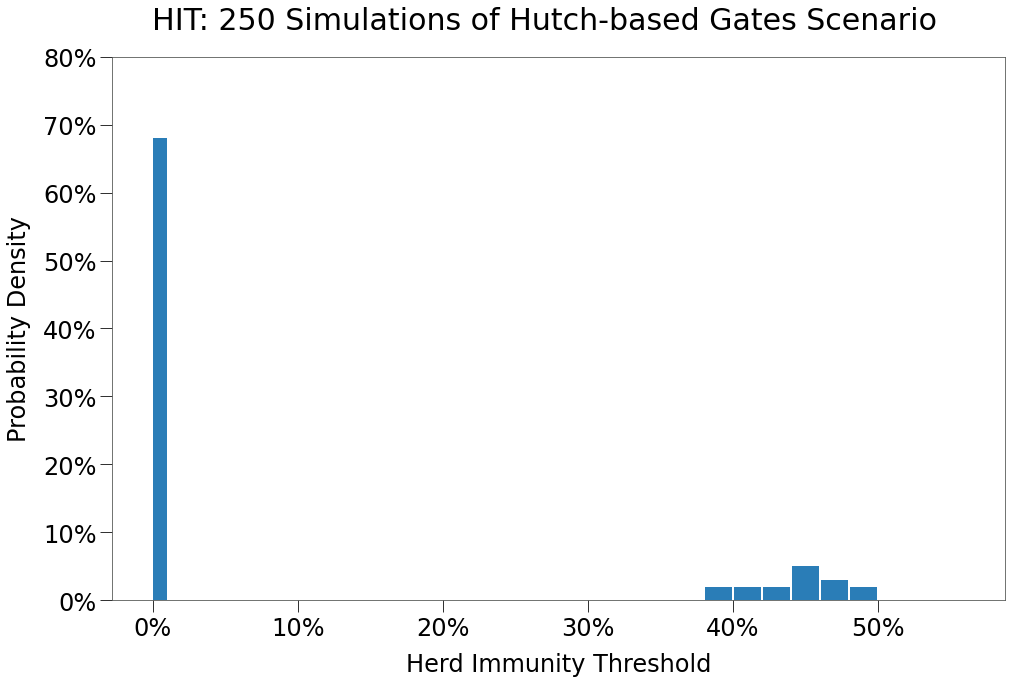

In [14]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/gates_hist'

title = r'HIT: 250 Simulations of Hutch-based Gates Scenario'
curvehist([res1[:,1]], title=title, which='hit', savepath=savepath)

In [15]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    
    modulereload(us_w_load_18)
    
    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        print (res)
        if .42 < res[1]:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/gates'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

In [17]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'gates.mp4')

And now we generate a representative simulation:

In [18]:
from rknot.notebook import animHTML
display(HTML(animHTML('us_w_load/gates')))

The results are shown below compared to SIR scenario:

In [19]:
from rknot.notebook import md, curve_table

import shelve
sirfile = 'vids/baseus/tables'

with shelve.open(sirfile, writeback=True) as db:
    sirres = db['6']

sirres = np.char.strip(sirres, '%').astype(np.float)
sirres[:6] /= 100

headers = ['Hutch', 'SIR']
results = [res, sirres]
display(HTML(curve_table(headers, results, style='results')))

,Hutch,SIR
Peak,39.6%,30.0%
HIT,44.9%,62.0%
Total,55.9%,83.0%
Fatalities,0.30%,0.52%
%>70,80.0%,40.0%
IFR,0.54%,0.62%
Days to Peak,58,66


Again, relative to SIR, the simulation has lower, but steeper peak with a faster decline once HIT is reached. Also consistent with the Events scenario, a larger proportion of the fatalities are experienced among the elderly.

### 3. Restrict Large Gatherings ###

As with the [SIR Model simulations](sir.ipynb#Policy), we can explore the impact of policy restrictions on spread in our more sophisticated environment. First, we will restrict large gatherings.

We'll again restrict gatherings with 10+ capacity. We assume this policy is implemented on day 30. The restriction will last for 120 days.

With a gamma distributed contact distribution, a very large number of contacts can be eliminated by eliminating just a small fraction of events.

In [20]:
from rknot.sims import us_w_load_18
from rknot.notebook import modulereload

modulereload(us_w_load_18)

In [35]:
text = f'Below we see that events with capacity 10+ represent just {per:.1%} of all events:'
md(text)

Below we see that events with capacity 10+ represent just 17.9% of all events:

In [36]:
import numpy as np

caps = np.array([e.capacity for e in us_w_load_18.events_gated])
n_events = caps.shape[0]
n_events_gt10 = np.bincount(caps)[10:].sum()
per = n_events_gt10 / n_events

In [37]:
table = f'''
    <table>
        <thead>
            <tr>
                <th class="results-table"># of Events</th>
                <th class="results-table">Events<br>Cap > 10</th>
                <th class="results-table">%</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td class="results-table">{n_events:,.0f}</td>
                <td class="results-table">{n_events_gt10:,.0f}</td>
                <td class="results-table">{per:.1%}</td>
            </tr>
        </tbody>
    </table>
'''
display(HTML(table))

# of Events,EventsCap > 10,%
"9,176","1,639",17.9%


In [103]:
text = f'And that these events represent {c_per:.1%} of all contacts generated by those events:'
md(text)

And that these events represent 83.8% of all contacts generated by those events:

In [104]:
counts, bins = np.histogram(caps-1, bins=np.arange(max(caps) + 1))
contacts = counts*(np.arange(counts.shape[0])+1)
c_gt10 = np.sum(contacts[10:]*np.arange(10, contacts[10:].shape[0] + 10))
c = np.sum(contacts*np.arange(contacts.shape[0]))
c_per = c_gt10 / c

In [105]:
table = f'''
    <table>
        <thead>
            <tr>
                <th class="results-table"># of Events</th>
                <th class="results-table">Events<br>Cap > 10</th>
                <th class="results-table">%</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td class="results-table">{c:,.0f}</td>
                <td class="results-table">{c_gt10:,.0f}</td>
                <td class="results-table">{c_per:.1%}</td>
            </tr>
        </tbody>
    </table>
'''
display(HTML(table))

# of Events,EventsCap > 10,%
"992,180","831,318",83.8%


The updated structure is as follows:

```python
from rknot.events import Restriction

lg = Restriction(name='large', start_tick=30, duration=120, criteria={'capacity': 10})

events_w_res = events_gated + [lg]

params = {'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 'vboxes': vbox, 'events': events_w_res}

sim = Sim(**params)
sim.run(dotlog=True)

chart = Chart(sim).to_html5_video()
```

We again show the average results of 250 simulations in the table below:

In [40]:
from rknot.helpers import ShelfHelp

resadhkey = {}
args = []
for adh in [0, .1, .25, .5, .8, 1]:
    file = f'tests/data/load_lg_adh_{adh*100:.0f}'
    key = f'load_lg_adh_{adh*100:.0f}_iters_RESULTS'
    with ShelfHelp(file, key, no_input=True, load=True) as sh:
        resadhkey[adh] = sh.values(*args)

resmaxkey = {}
args = []
for cap in [25, 50, 75]:
    file = f'tests/data/load_lg_{cap}max'
    key = f'load_lg_{cap}max_iters_RESULTS'

    with ShelfHelp(file, key, no_input=True, load=True) as sh:
        resmaxkey[cap] = sh.values(*args)

In [41]:
from IPython.core.display import display, HTML
import numpy as np
from rknot.notebook import curve_table, md
from rknot.helpers import find_means, find_means_seconly, find_seconly

headers = ['10Max', r'10Max<br>$R_0$ > 0'] 
means = find_means(resadhkey[1][-1])
means_seconly = find_means_seconly(resadhkey[1][-1], means)

args = [means, means_seconly]
sizes = [resadhkey[1][-1].shape[0], find_seconly(resadhkey[1][-1]).shape[0]]

display(HTML(curve_table(headers, args, sizes)))

,10Max,10Max$R_0$ > 0
n,250,53
Peak,1.3%,5.6%
HIT,1.3%,5.9%
Total,1.4%,6.1%
Fatalities,0.02%,0.10%
%>70,81.4%,81.4%
IFR,0.36%,1.38%
Days to Peak,15,39
$R_0$ = 0,48.0%,0.0%


We can see that restricting contacts to a maximum of 10 per day has a dramatic impact on spread, reducing the total amount of infections and significantly shortening the duration.

We can see below that the vast majority (almost 80%) of simulations resulted in no outbreak at all. Note, however, that some simulations resulted in moderate outbreaks. So given enough iterations (say among different municipalities, provinces, states or countries), a significant outbreak is sure to occur despite the best efforts of policy.

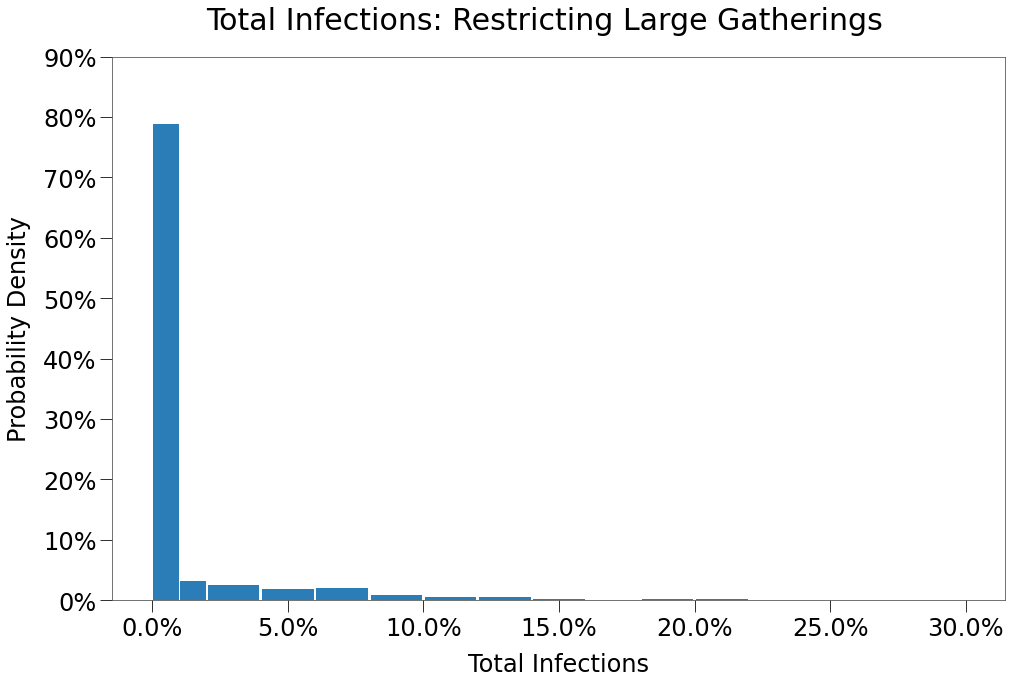

In [42]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/large_gatherings_hist'
title = r'Total Infections: Restricting Large Gatherings'

curvehist([resadhkey[1][-1][:,2]], title=title, which='tot', savepath=savepath)

In [43]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    
    modulereload(us_w_load_18)
    
    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 10}
    )
    events_w_res = us_w_load_18.events_gated + [large_gatherings]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        if .05 < res[1]:
            print (res)
            break    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload, get_results
file = 'vids/us_w_load/large_gatherings'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

In [45]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'large_gatherings.mp4')

In [46]:
from rknot.notebook import animHTML
display(HTML(animHTML('us_w_load/large_gatherings')))

The results of the simulation are shown in the table below, compared with the same scenario from the SIR model simulations:

In [47]:
import shelve
sirfile = 'vids/baseus/tables'

with shelve.open(sirfile, writeback=True) as db:
    sirres = db['large']

sirres = np.char.strip(sirres, '%').astype(np.float)
sirres[:6] /= 100

results = [res, sirres]

headers = ['Hutch', 'SIR']
display(HTML(curve_table(headers, results, style='results')))

,Hutch,SIR
Peak,10.7%,15.0%
HIT,13.1%,28.0%
Total,13.6%,73.0%
Fatalities,0.24%,0.45%
%>70,95.8%,38.0%
IFR,1.77%,0.62%
Days to Peak,49,69


The Hutch model results in a far more muted curve. This [aligns with research](https://www.medrxiv.org/content/10.1101/2020.08.07.20169920v3.full.pdf) that indicates super-spreader events (where a single individual is responsible for a large number of secondary infections) are responsible for the vast majority of secondary infections.

When those superspreader events are eliminated, spread is curtailed.

This result is somewhat confounding, however, given that many jurisidictions across the global have implemented a similar policy without such a dramatic impact.

Some reasons for this deviation may include:

1. few policies have truly limited all people to less than 10 contacts per day for 120 days. Often there have been exemptions for essential services. For example, during the second wave in North America, many children continued to go to school.
2. adherence to such policies is likely not 100%.
3. mixing amongst jurisdictions with different policies

As a means of rough investigation, simulations were ran for a dozen scenarios of different maximum event capacities and adherence factors (and some combinations). The results are shown in the tables below:

In [48]:
import numpy as np
from rknot.notebook import curve_table, md
from rknot.helpers import find_means, find_means_seconly, find_seconly

head = [f'{k}Max' for k in resmaxkey.keys()]
headex = [h + r'<br>$R_0$ > 0' for h in head]
headers = head + headex

vals = [v[4] for v in resmaxkey.values()]
means = [find_means(val) for val in vals]
means_seconly = [find_means_seconly(vals[i], means[i]) for i in range(len(vals))]
sizes = [val.shape[0] for val in vals] + [find_seconly(val).shape[0] for val in vals]

args = means + means_seconly

display(HTML(curve_table(headers, args, sizes)))

,25Max,50Max,75Max,25Max$R_0$ > 0,50Max$R_0$ > 0,75Max$R_0$ > 0
n,250,250,250,67,56,67
Peak,1.7%,3.4%,6.6%,6.1%,15.0%,24.4%
HIT,1.8%,5.3%,8.7%,6.6%,23.3%,32.2%
Total,2.0%,7.3%,11.6%,7.3%,32.4%,43.0%
Fatalities,0.03%,0.06%,0.09%,0.12%,0.26%,0.33%
%>70,76.0%,82.5%,82.4%,76.0%,82.5%,82.4%
IFR,0.91%,0.42%,0.36%,1.29%,0.86%,0.74%
Days to Peak,16,25,24,44,97,75
$R_0$ = 0,59.6%,63.2%,52.4%,0.0%,0.0%,0.0%


And below the results of different adherence factors for a policy of maximum capacity 10. Adherence of 100 means full compliance and matches the first scenario above. Aherence of 0 means no compliance and outcomes match that of the [Gates scenario](#2.-Gates) above.

We have split the table in two sections, one with all simulations and the second showing only those with seconedary infections.

In [49]:
head = [f'{adh*100:.0f}ADH' for adh in resadhkey.keys()]
vals = [v[4] for v in resadhkey.values()]
means = [find_means(val) for val in vals]
sizes = [val.shape[0] for val in vals]

display(HTML(curve_table(head, means, sizes)))

,0ADH,10ADH,25ADH,50ADH,80ADH,100ADH
n,250,100,100,100,100,250
Peak,11.1%,6.9%,6.1%,1.4%,1.1%,1.3%
HIT,13.7%,10.5%,7.8%,1.5%,1.2%,1.3%
Total,16.9%,13.3%,11.3%,1.7%,1.2%,1.4%
Fatalities,0.12%,0.10%,0.10%,0.02%,0.02%,0.02%
%>70,81.3%,84.8%,80.8%,73.4%,75.7%,81.4%
IFR,0.24%,0.27%,0.36%,0.28%,0.32%,0.36%
Days to Peak,27,32,26,16,12,15
$R_0$ = 0,49.2%,54.0%,48.0%,50.0%,57.0%,48.0%


In [50]:
headex = [h + r'<br>$R_0$ > 0' for h in head]
vals = [v[4] for v in resadhkey.values()]
means_seconly = [find_means_seconly(vals[i], means[i]) for i in range(len(vals))]
sizes = [find_seconly(val).shape[0] for val in vals]

display(HTML(curve_table(headex, means_seconly, sizes)))

,0ADH$R_0$ > 0,10ADH$R_0$ > 0,25ADH$R_0$ > 0,50ADH$R_0$ > 0,80ADH$R_0$ > 0,100ADH$R_0$ > 0
n,77,30,31,22,17,53
Peak,35.9%,23.0%,19.6%,6.1%,6.2%,5.6%
HIT,44.4%,35.0%,25.2%,6.7%,6.7%,5.9%
Total,54.7%,44.3%,36.2%,7.6%,7.0%,6.1%
Fatalities,0.39%,0.33%,0.31%,0.10%,0.11%,0.10%
%>70,81.3%,84.8%,80.8%,73.4%,75.7%,81.4%
IFR,0.71%,0.76%,0.86%,1.07%,1.28%,1.38%
Days to Peak,74,95,71,46,41,39
$R_0$ = 0,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


In [51]:
from rknot.helpers import ShelfHelp

reskey = {}
args = []
for cap in [25, 50]:
    reskey[cap] = {}
    for adh in [.5, .8]:
        file = f'tests/data/load_lg_adh_{int(adh*100)}_{cap}max'
        key = f'load_lg_adh_{int(adh*100)}_{cap}max_iters_RESULTS'

        with ShelfHelp(file, key, no_input=True, load=True) as sh:
            reskey[cap][adh] = sh.values(*args)

Finally, we combined limited adherence with some other maximum capacity policies, as per the table below:

In [52]:
head = [f'{cap}Max<br>{adh*100:.0f}ADH' for cap, subk in reskey.items() for adh in subk.keys()]
vals = [v1[4] for v0 in reskey.values() for v1 in v0.values()]

means_seconly = [find_means_seconly(vals[i], means[i]) for i in range(len(vals))]
sizes = [find_seconly(val).shape[0] for val in vals]

display(HTML(curve_table(head, means_seconly, sizes)))

,25Max50ADH,25Max80ADH,50Max50ADH,50Max80ADH
n,72,58,59,61
Peak,14.6%,7.3%,28.2%,16.3%
HIT,18.8%,8.2%,36.6%,23.9%
Total,23.6%,9.3%,48.2%,36.0%
Fatalities,0.24%,0.14%,0.38%,0.31%
%>70,81.3%,84.8%,80.8%,73.4%
IFR,1.07%,1.29%,0.77%,0.89%
Days to Peak,73,49,73,86
$R_0$ = 0,0.0%,0.0%,0.0%,0.0%


What we find in the data above is:

1. restricting capacity is very impactful right up to 75 max capacity. So restricting only just the very largest events *should* have a moderating effect on spread.
2. adherence factor has only a very modest impact on spread at the higher factors. If fully 20% of subjects are not observing the prescribed policies, this shouldn't lead to dramatic increase in spread. Even at 50% adherence, spread is significantly muted relative to no policy at all.

For comparison purposes, we will show a sample simulation of the 25 Max, 50% adherence scenario.

```python
from rknot.events import Restriction

lg = Restriction(name='large', start_tick=30, duration=120, criteria={'capacity': 25}, adherence=.5)

events_w_res = events_gated + [lg]

params = {'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 'vboxes': vbox, 'events': events_w_res}

sim = Sim(**params)
sim.run(dotlog=True)

chart = Chart(sim).to_html5_video()
```

In [53]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    
    modulereload(us_w_load_18)
    
    large_gatherings = Restriction(
        name='large', start_tick=30, duration=120, criteria={'capacity': 25},
        adherence=0.5,
    )
    events_w_res = us_w_load_18.events_gated + [large_gatherings]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)

        res = get_results(sim)
        print (res)
        if .14 < res[1]:
            break    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from datetime import datetime as dt
import pickle
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/lg_25max_50adh'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)
    
lgfile = 'vids/us_w_load/large_gatherings'
lgsims = pickload(lgfile)
lgrun_date, lgsim = sorted(lgsims.items())[-1] # Get the most recent saved sim
res_lg = get_results(lgsim)

In [55]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'lg_25max_50adh.mp4')

In [56]:
from rknot.notebook import animHTML
display(HTML(animHTML('us_w_load/lg_25max_50adh')))

The results of th sim are shown below in comparison to our base 10 max capacity scenario:

In [57]:
import shelve

results = [res, res_lg]
headers = ['25Max<br>50Adh', '10Max<br>100Adh']

display(HTML(curve_table(headers, results, style='results')))

,25Max50Adh,10Max100Adh
Peak,24.5%,10.7%
HIT,27.3%,13.1%
Total,33.5%,13.6%
Fatalities,0.38%,0.24%
%>70,92.1%,95.8%
IFR,1.14%,1.77%
Days to Peak,52,49


### 4. Social Distancing ###

We will now investigate the impact of social distancing measures [as outlined here](sir.ipynb#2.-Social-Distancing).

We provice `tmfs` to each age group, representing the adherence to and impact of various tactics including 6-feet of distance, masks, hand sanitizer, etc.

The policy measure is implemented on day 30 and maintained for 120 days.

Note we set `group2b` to `tmf=.5`, indicating much striter adherence to social distancing practices than its age cohort (which is likely consistent with care home workers in the real world).

```python
from rknot.events import SocialDistancing as SD

sd = SD(name='all', tmfs=[.8, .8, .5, .7,.65,.5], groups=[0,1,2,3,4,5], start_tick=30, duration=120)

events_w_res = events_gated + [sd]

params = {
    'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 
    'vboxes': {'label': 'Events', 'box': 344}, 'events': us_w_load_18.events
}

sim = Sim(**params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [58]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.notebook import modulereload
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

modulereload(us_w_load_18)

file = 'tests/data/load_sd'
key = 'load_sd_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if False:
    from rknot.helpers import looper
    from rknot.events import Restriction, SocialDistancing as SD

    sd = SD(
        name='all', tmfs=[.8,.8,.5,.7,.65,.5], 
        groups=[0,1,2,3,4,5], start_tick=30, duration=120
    )
    events_w_res = us_w_load_18.events_gated + [sd]

    us_w_load_18.params_gated['events'] = events_w_res
    
    n = 25
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



The average results of 250 iterations of the scenario are shown in the table below:

In [59]:
import numpy as np

from rknot.notebook import curve_table, md

headers = ['SD', r'SD<br>$R_0$ > 0']
means = find_means(res1)
args = [means, find_means_seconly(res1, means)]
sizes = [res1.shape[0], find_seconly(res1).shape[0]]

display(HTML(curve_table(headers, args, sizes)))

,SD,SD$R_0$ > 0
n,25,7
Peak,2.1%,7.3%
HIT,2.4%,8.3%
Total,2.8%,9.9%
Fatalities,0.03%,0.11%
%>70,84.0%,84.0%
IFR,0.36%,1.28%
Days to Peak,19,54
$R_0$ = 0,52.0%,0.0%


The distribution of infections is heavily skewed towards zero with fairly volatile deviations at the margin.

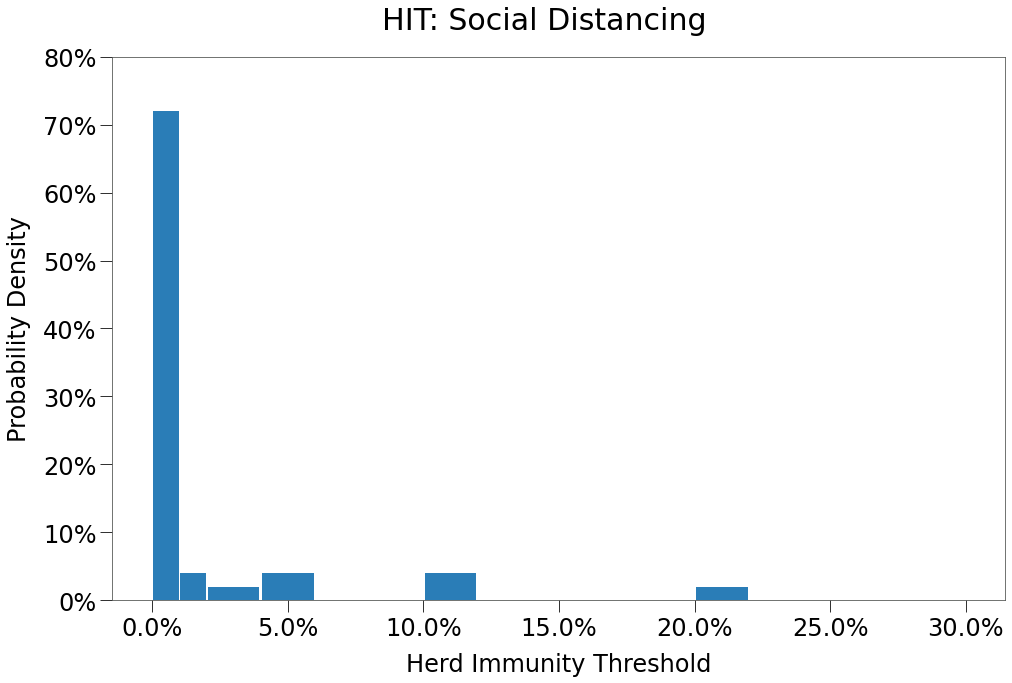

In [60]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/social_distancing'

title = r'HIT: Social Distancing'
curvehist([res1[:,1]], title=title, which='hit', savepath=savepath)

In [61]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.sims import us_w_load_18
    from rknot.events import SocialDistancing as SD
    
    modulereload(us_w_load_18)
    
    sd = SD(
        name='all', tmfs=[.8,.8,.8,.7,.65,.5], 
        groups=[0,1,2,3,4,5], start_tick=30, duration=120
    )
    events_w_res = us_w_load_18.events_gated + [sd]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)
        
        res = get_results(sim)
        print (res)
        if .13 < res[1]:
            break    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload
file = 'vids/us_w_load/social_distancing'

if SAVE:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

In [63]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'social_distancing.mp4')

In [106]:
from rknot.notebook import animHTML
display(HTML(animHTML('us_w_load/social_distancing')))

The results of the simulation are compared to the SIR model below:

In [66]:
from rknot.notebook import md, curve_table
import shelve
sirfile = 'vids/baseus/tables'

with shelve.open(sirfile, writeback=True) as db:
    sirres = db['policy_sd']

sirres = np.char.strip(sirres, '%').astype(np.float)
sirres[:6] /= 100

results = [res, sirres]
headers = ['Hutch', 'SIR']
display(HTML(curve_table(headers, results, style='results')))

,Hutch,SIR
Peak,13.4%,8.0%
HIT,14.2%,24.0%
Total,17.8%,68.0%
Fatalities,0.13%,0.39%
%>70,69.2%,33.0%
IFR,0.73%,0.57%
Days to Peak,49,96


Here we see that social distancing practices have a much more dramatic impact on spread in the Hutch model than the SIR. There are fewer infections and the outbreak declines much faster, avoiding the very long, slow tail evident in SIR.

A lower $R_0$ is in part responsible, but so too is the viral load curve in Hutch, which has a longer *infection* duration but a much shorter truly *infectious* period.

### 5. Restrict Elderly Visits ###

Again, as with the [SIR simulations](sir.ipynb#3.-Restrict-Elderly-Visits), we will restrict visits to the elderly, HOWEVER, care home workers will continue to have access.

The policy measure is implemented on day 30 and maintained for another 120 days. There will be no other restrictions.

```python
no_visits = Restriction(name='no_visits', start_tick=30, duration=120, criteria={'name': 'visit'})

events_w_res = events_gated + [no_visits]

params = {'groups': groups, 'density': 1, 'days': 365, 'tmr_curve': tmr, 'vboxes': vbox, 'events': us_w_load_18.events}

sim = Sim(**params)
sim.run()

chart = Chart(sim, use_init_func=True)
chart.animate.to_html5_video()
```

In [67]:
from rknot import Sim
from rknot.sims import us_w_load_18
from rknot.notebook import modulereload
from rknot.helpers import ShelfHelp
from rknot.dots.fhutch import tmr

modulereload(us_w_load_18)

file = 'tests/data/load_elderly'
key = 'load_elderly_iters_RESULTS'
simbase = us_w_load_18.__name__.split('.')[-1]

if False:
    from rknot.helpers import looper
    from rknot.events import Restriction

    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=120, criteria={'name': 'visit'}
    )
    events_w_res = us_w_load_18.events_gated + [no_visits]

    us_w_load_18.params_gated['events'] = events_w_res
    
    n = 50
    contacts, nsecs, results, exceptions = looper(
        n, sterile=False, **us_w_load_18.params_gated
    )

In [68]:
try:
    tgt_R0 = 1.8
    mu = 4
    theta = 40
    args = n, contacts, nsecs, results, tmr, simbase, tgt_R0, mu, theta
except NameError:
    args = []
with ShelfHelp(file, key) as sh:
    n, tmr, c1, nsecs, res1 = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



Below we see the results of 250 simulations of the scenario:

In [69]:
import numpy as np
from IPython.core.display import display, HTML

from rknot.notebook import curve_table, md
from rknot.helpers import find_means, find_means_seconly, find_seconly

headers = ['No Visits', r'No Visits<br>$R_0$ > 0']
means = find_means(res1)
means_seconly = find_means_seconly(res1, means)
sizes = [res1.shape[0], find_seconly(res1).shape[0]]

args = [means, means_seconly]
    
display(HTML(curve_table(headers, args, sizes)))

,No Visits,No Visits$R_0$ > 0
n,50,13
Peak,8.8%,33.7%
HIT,11.0%,42.2%
Total,13.6%,52.3%
Fatalities,0.10%,0.38%
%>70,86.2%,86.2%
IFR,0.33%,0.67%
Days to Peak,23,75
$R_0$ = 0,54.0%,0.0%


Below we can see the distribution of HIT among the different iterations. Given the restrictions on contacts are very limited in the general population, HIT is very similar to that of the [Gates scenario](#2.-Gates).

In [70]:
from rknot.notebook import curvehist
savepath = 'vids/us_w_load/elderly_visits'

file = 'tests/data/load_gates'
key = 'load_gates_iters_RESULTS'
args = []
with ShelfHelp(file, key) as sh:
    n, sim_tmr, c1, nsecs1, res_gates = sh.values(*args)

This date does not exist for the specified key.
Enter 0 to use the most recent date (default).
Enter 1 to add a new entry.



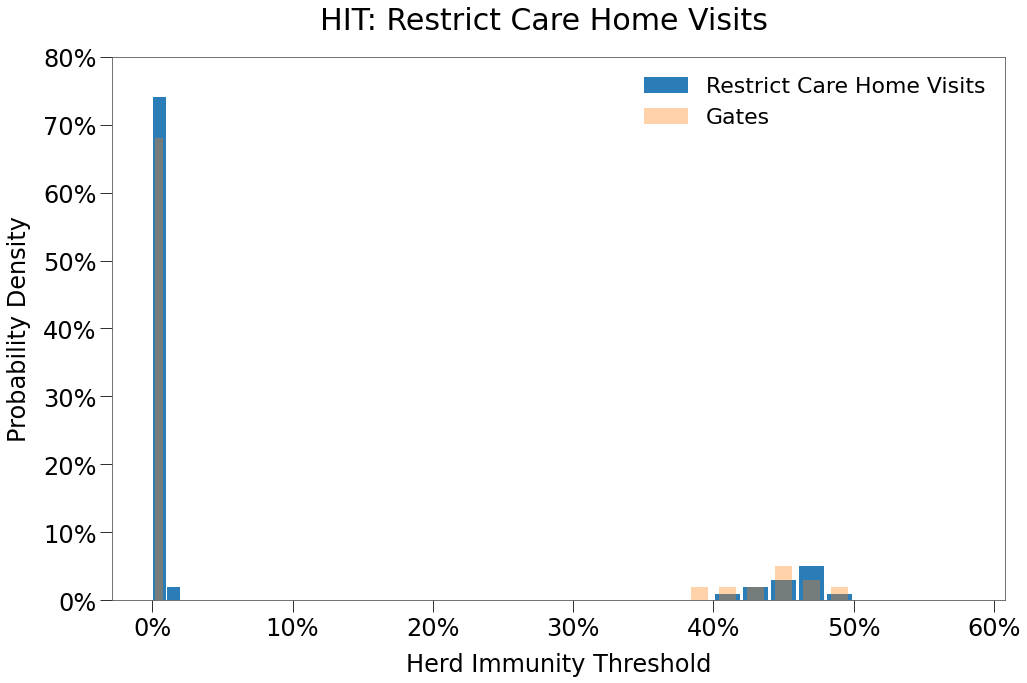

In [71]:
labels = ['Restrict Care Home Visits', 'Gates']
title = r'HIT: Restrict Care Home Visits'
widths = [.9, .6]
curvehist([res1[:,1], res_gates[:,1]], widths=widths, labels=labels, title=title, which='hit', savepath=savepath)

In [72]:
%load_ext autoreload
%autoreload 2

if RUN:
    from rknot.sim import recycler
    from rknot.helpers import get_results
    from rknot.notebook import modulereload
    from rknot.dots import MATRIX_COL_LABELS as ML
    from rknot.sims import us_w_load_18
    from rknot.events import Restriction
    
    modulereload(us_w_load_18)
    
    no_visits = Restriction(
        name='no_visits', start_tick=30, 
        duration=120, criteria={'name': 'visit'}
    )
    events_w_res = us_w_load_18.events_gated + [no_visits]

    us_w_load_18.params_gated['events'] = events_w_res

    sim_cycler = recycler(100)
    while True:    
        sim = sim_cycler(pbar_leave=False, pbar=False, **us_w_load_18.params_gated)
        sim.run(dotlog=True, pbar_leave=False, pbar=False)
        
        res = get_results(sim)
    
        dots = sim.dotlog[29]
        inf5 = dots[dots[:, ML['is_inf']] == 1]
        print (res, inf5.shape[0])
        if .42 < res[1] and inf5.shape[0] == 0:
            break    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
from datetime import datetime as dt
from rknot.helpers import picksave, pickload, get_results
file = 'vids/us_w_load/elderly_visits'

if False:
    delattr(sim, 'server')
    delattr(sim, 'workers')
    sims = pickload(file)
    sims[dt.now()] = sim
    picksave(file, sims)

    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
else:
    sims = pickload(file)
    run_date, sim = sorted(sims.items())[-1] # Get the most recent saved sim
    res = get_results(sim)

In [74]:
if SAVE_CHARTS:
    from rknot import Chart
    PATH = 'vids/us_w_load/tests/'
    chart_params = dict(reso_format='web', dotsize=.1)
    chart = Chart(sim, show_intro=True, show_restricted=True, **chart_params).save(PATH + 'elderly_visits.mp4')

In [76]:
from rknot.notebook import animHTML
display(HTML(animHTML('us_w_load/elderly_visits')))

The results of the simulation are shown below:

In [77]:
from rknot.notebook import md
import shelve
sirfile = 'vids/baseus/tables'

with shelve.open(sirfile, writeback=True) as db:
    sirres = db['no_visits']

sirres = np.char.strip(sirres, '%').astype(np.float)
sirres[:6] /= 100

headers = ['Hutch', 'SIR']
results = [res, sirres]
display(HTML(curve_table(headers, results, style='results')))

,Hutch,SIR
Peak,45.6%,27.0%
HIT,50.2%,54.0%
Total,56.8%,80.0%
Fatalities,0.28%,0.29%
%>70,82.1%,17.0%
IFR,0.49%,0.36%
Days to Peak,53,77


So the outbreak in the sample simulation is on par with that in SIR, with the usual steeper slope and shorter duration.

Fatalities in this particular sim are also on par with SIR, however, the average values were much higher than SIR and relative to the total infections, fatalities were much higher in Hutch. Fatalities were skewed much higher towards the >70 age group as well.

We can see from the animation that around tick 50 an outbreak occurs in the 70+G gated area. This did not occur in the SIR simulation.

We can investigate this by analyzing the `dotlog`.

Below we can see that the restrictions were successful in limiting infections inside the gate up to tick 40. On tick 40, however, 4 infections occured within the group and that expanded to 19 infections by tick 44.

In [79]:
from rknot import Sim
from rknot.dots import MATRIX_COL_LABELS as ML
infs_in_70g = []
for i in range(30, 45):
    dots = sim.dotlog[i]
    g5s = dots[dots[:, ML['group_id']] == 5]
    inf5 = g5s[g5s[:, ML['is_inf']] == 1]
    infs_in_70g.append((i, inf5.shape[0]))
print (infs_in_70g)

[(30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 4), (41, 4), (42, 4), (43, 4), (44, 19)]


We can focus in on tick 39 to see how the virus entered the gate.

First, we find the subjects inside the gate on tick 39.

In [83]:
dots = sim.dotlog[39]
gate_locs = sim.gates[0]['locs']
dots_in_gate = dots[np.isin(dots[:, ML['loc_id']], gate_locs[:,0])]
print (dots_in_gate.shape[0])

307


In [84]:
text = f'There were {dots_in_gate.shape[0]} subjects inside the gate on tick 39.'
md(text)

There were 307 subjects inside the gate on tick 39.

In [85]:
not5_in_gate = dots_in_gate[dots_in_gate[:, ML['group_id']] != 5]
print (not5_in_gate.shape[0])

7


In [96]:
text = f'Of those {dots_in_gate.shape[0]} subjects, {not5_in_gate.shape[0]} were not in the ' 
text += f'70+G group. In fact, all {not5_in_gate.shape[0]} ' 
text += f'are home care workers (`group_id=2`). '
text += 'Below we show the slice of the dot matrix showing the home care workers inside the gate on tick 39.'
md(text)

Of those 307 subjects, 7 were not in the 70+G group. In fact, all 7 are home care workers (`group_id=2`). Below we show the slice of the dot matrix showing the home care workers inside the gate on tick 39.

In [97]:
print (not5_in_gate)

[[  6734      2      1      0      1      0      0    412      5      5
    9305     92     24      0   9168 119684      6     98    100     20
      -1     -1     -1     -1      0      1]
 [  6737      2      1      0      1      0      0    207      3      4
    1647     17     16      0   9167 119320      6     98    100     20
      -1     -1     -1     -1      0      1]
 [  6750      2      1      0      1      0      0    309      4      4
   10124    100     27      0   9155 114952      6     98    100     20
      -1     -1     -1     -1      0      1]
 [  6770      2      1      0      1      0      0    104      2      3
    9027     89     52      0   9160 116772      6     98    100     20
      -1     -1     -1     -1      0      1]
 [  6780      2      1      0      0      1      1    408      5      1
    7166     71     27      0   9147 112040      6     98    100     20
      35     -1     66    432      0      1]
 [  6785      2      1      0      1      0      0    2

If we inspect the matrix above closely, we can see that only one subject is infected, subject `id=6780`.

We can isolate this subject below:

In [98]:
not5_in_gate[not5_in_gate[:,ML['is_inf']] == 1]

array([[  6780,      2,      1,      0,      0,      1,      1,    408,
             5,      1,   7166,     71,     27,      0,   9147, 112040,
             6,     98,    100,     20,     35,     -1,     66,    432,
             0,      1]], dtype=int32)

So restricting eldery visits is ultimately a meaningless and ineffectual policy if home care workers enter the gate without obstruction. Obviously, it is not a solution to restrict home care workers from entering the gate.

One possibility is to implement a testing regime.

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [102]:
from rknot.notebook import move_to_doc_folder
move_to_doc_folder('load.ipynb')